# Interaction Mode Cluster Evaluation

This notebook evaluates the clustering results in `interaction_mode_results` in relation to the per-dataset feature analysis produced by the cluster selection pipeline. It uses outputs and functions from `interaction_mode_cluster_selection_v2.py` and `interaction_mode_features_v2.py`.

In [16]:
# Import Required Libraries and Custom Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import sys

# Add source_code_package to sys.path for custom imports
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("../"), 'source_code_package')))

# Import custom functions (using importlib for robustness)
import importlib.util
features_path = os.path.abspath(os.path.join(os.path.dirname("../"), 'source_code_package', 'features', 'interaction_mode_features_v2.py'))
spec = importlib.util.spec_from_file_location('interaction_mode_features_v2', features_path)
interaction_mode_features_v2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(interaction_mode_features_v2)

# Optionally, import cluster selection script functions if needed
# (Assume all relevant functions are in interaction_mode_features_v2 for this notebook)


In [17]:
# Load interaction_mode_results Data
# Example: Load cluster labels and raw clustering results for each dataset
results_dir = '../data/raw_data/interaction_mode_results'

def load_cluster_labels(dataset_name):
    if dataset_name == 'main':
        path = os.path.join(results_dir, 'main_clustering/hdbscan_results/cluster_labels.csv')
    else:
        path = os.path.join(results_dir, f'{dataset_name}_clustering/hdbscan_results/cluster_labels.csv')
    return pd.read_csv(path)

# Load for all datasets
dataset_names = ['main', 'cluster_0', 'cluster_1']
cluster_labels = {name: load_cluster_labels(name) for name in dataset_names}

# Optionally preview one
cluster_labels['main'].head()

,cluster_label
0,9
1,-1
2,15
3,5
4,23


In [18]:
# Load Feature Analysis Data per Dataset
# Load the YAML output from the cluster selection script
feature_analysis_path = '../data/processed_data/interaction_mode_cluster_selections_v2.yaml'

with open(feature_analysis_path, 'r') as f:
    feature_analysis = yaml.safe_load(f)

# Extract per-dataset feature selections
dataset_feature_selections = feature_analysis['datasets']

# Preview the structure
list(dataset_feature_selections.keys()), dataset_feature_selections['main'].keys()

(['cluster_0', 'cluster_1', 'main'],
 dict_keys(['feature_selections', 'noise_points', 'total_points', 'valid_clusters']))

In [19]:
# Merge Results with Feature Analysis
# For each dataset, join the cluster labels with the selected cluster and feature stats

def merge_labels_with_feature_analysis(dataset_name):
    labels_df = cluster_labels[dataset_name].copy()
    feature_selections = dataset_feature_selections[dataset_name]['feature_selections']
    # Add a column for each feature indicating if the row is in the selected cluster
    for feature, sel in feature_selections.items():
        labels_df[f'{feature}_is_selected_cluster'] = (labels_df['cluster_label'] == sel['selected_cluster'])
    return labels_df

merged_dfs = {name: merge_labels_with_feature_analysis(name) for name in dataset_names}

# Preview merged dataframe for 'main'
merged_dfs['main'].head()

,cluster_label,BRIDGE_EVENTS_is_selected_cluster,CEX_EVENTS_is_selected_cluster,DEFI_EVENTS_is_selected_cluster,DEX_EVENTS_is_selected_cluster
0,9,False,False,False,False
1,-1,False,False,False,False
2,15,True,False,False,False
3,5,False,False,False,False
4,23,False,False,False,False


In [20]:
# Evaluate Results per Dataset
# Compute evaluation metrics for each dataset and feature

evaluation_metrics = {}
for dataset_name in dataset_names:
    df = merged_dfs[dataset_name]
    metrics = {}
    for feature in dataset_feature_selections[dataset_name]['feature_selections']:
        is_selected = df[f'{feature}_is_selected_cluster']
        prop_in_selected = is_selected.mean()
        metrics[feature] = {
            'proportion_in_selected_cluster': prop_in_selected,
            'selected_cluster': dataset_feature_selections[dataset_name]['feature_selections'][feature]['selected_cluster'],
            'median_value': dataset_feature_selections[dataset_name]['feature_selections'][feature]['median_value'],
            'activity_rate': dataset_feature_selections[dataset_name]['feature_selections'][feature]['feature_stats']['non_zero_proportion']
        }
    evaluation_metrics[dataset_name] = metrics

# Show evaluation metrics for 'main'
pd.DataFrame(evaluation_metrics['main']).T

,proportion_in_selected_cluster,selected_cluster,median_value,activity_rate
BRIDGE_EVENTS,0.023496,15.0,6.0,1.000000
CEX_EVENTS,0.015912,6.0,0.0,0.411215
DEFI_EVENTS,0.019332,7.0,3.0,1.000000
DEX_EVENTS,0.014672,17.0,1.0,0.564189


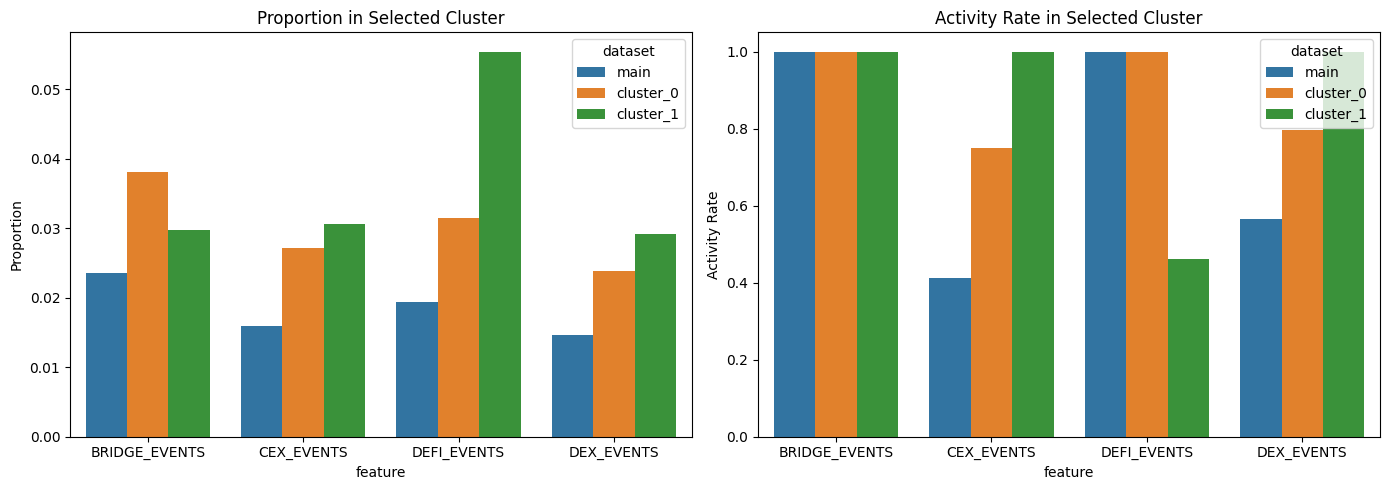

In [21]:
# Visualize Evaluation Metrics
# Bar plots for proportion in selected cluster and activity rate per feature and dataset

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for plotting
plot_data = []
for dataset_name, metrics in evaluation_metrics.items():
    for feature, vals in metrics.items():
        plot_data.append({
            'dataset': dataset_name,
            'feature': feature,
            'proportion_in_selected_cluster': vals['proportion_in_selected_cluster'],
            'activity_rate': vals['activity_rate']
        })
plot_df = pd.DataFrame(plot_data)

sns.barplot(data=plot_df, x='feature', y='proportion_in_selected_cluster', hue='dataset', ax=axes[0])
axes[0].set_title('Proportion in Selected Cluster')
axes[0].set_ylabel('Proportion')

sns.barplot(data=plot_df, x='feature', y='activity_rate', hue='dataset', ax=axes[1])
axes[1].set_title('Activity Rate in Selected Cluster')
axes[1].set_ylabel('Activity Rate')

plt.tight_layout()
plt.show()

In [22]:
# Statistical Comparison Across Datasets
# Example: Kruskal-Wallis test for activity rates across datasets for each feature
from scipy.stats import kruskal

for feature in plot_df['feature'].unique():
    data = [plot_df[(plot_df['feature'] == feature) & (plot_df['dataset'] == ds)]['activity_rate'].values.flatten() for ds in dataset_names]
    # Flatten and ensure each group is 1D
    data = [d if d.ndim == 1 else d.ravel() for d in data]
    if all(len(d) > 0 for d in data):
        try:
            stat, p = kruskal(*data)
            print(f'Feature: {feature} | Kruskal-Wallis H={stat:.3f}, p={p:.3g}')
            for ds, vals in zip(dataset_names, data):
                print(f'  {ds}: {vals}')
        except ValueError as e:
            if 'All numbers are identical' in str(e):
                print(f'Feature: {feature} | All activity rates are identical across datasets. Kruskal-Wallis test not applicable.')
            else:
                print(f'Feature: {feature} | Error: {e}')
    else:
        print(f'Feature: {feature} | Not enough data for statistical test.')

Feature: BRIDGE_EVENTS | All activity rates are identical across datasets. Kruskal-Wallis test not applicable.
Feature: CEX_EVENTS | Kruskal-Wallis H=2.000, p=0.368
  main: [0.41121495]
  cluster_0: [0.75]
  cluster_1: [1.]
Feature: DEFI_EVENTS | Kruskal-Wallis H=2.000, p=0.368
  main: [1.]
  cluster_0: [1.]
  cluster_1: [0.46137787]
Feature: DEX_EVENTS | Kruskal-Wallis H=2.000, p=0.368
  main: [0.56418919]
  cluster_0: [0.79704797]
  cluster_1: [1.]
